In [24]:
import geopandas as gpd
import matplotlib.pyplot as plt
import geoplot
import pandas as pd
import numpy as np
import os
from shapely.geometry import Point
import re
from math import *
import csv
import xlrd
import copy

# load data

In [25]:
### load county shapefile
county_path = './data/UScounties/UScounties.shp'
shape_county = gpd.read_file(county_path)
# remove two state are not in the mainland of US
shape_county = shape_county[shape_county.STATE_NAME != 'Alaska']
shape_county = shape_county[shape_county.STATE_NAME != 'Hawaii']
# Display summary
# shape_county.info()
# shape_county

### load states 
state_path = './data/cb_2018_us_state_500k/cb_2018_us_state_500k.shp'
shape_state = gpd.read_file(state_path)
# remove states not in the mainland
shape_state = shape_state[shape_state.NAME != 'Alaska']
shape_state = shape_state[shape_state.NAME != 'Hawaii']
shape_state = shape_state[shape_state.NAME != 'Commonwealth of the Northern Mariana Islands']
shape_state = shape_state[shape_state.NAME != 'United States Virgin Islands']
shape_state = shape_state[shape_state.NAME != 'Puerto Rico']
shape_state = shape_state[shape_state.NAME != 'Guam']
shape_state = shape_state[shape_state.NAME != 'American Samoa']
# shape_state

### load state captial
capital_path = './data/us-state-capitals.csv'
data = pd.read_csv(capital_path)
# data
# convert state captial data into geometry
col_name = ["longitude","latitude"]
data["geometry"] = data.apply(lambda x: Point(x[col_name]),axis=1)
captial_data = gpd.GeoDataFrame(data)
captial_data.head()
captial_data = captial_data[captial_data.name != 'Alaska']
captial_data = captial_data[captial_data.name != 'Hawaii']
captial_data = captial_data[captial_data.name != 'Commonwealth of the Northern Mariana Islands']
captial_data = captial_data[captial_data.name != 'United States Virgin Islands']
captial_data = captial_data[captial_data.name != 'Puerto Rico']
captial_data = captial_data[captial_data.name != 'Guam']
captial_data = captial_data[captial_data.name != 'American Samoa']

In [26]:
df = gpd.GeoDataFrame(shape_county)

# calculate the distance and add to dataframe

(array([ 603., 1011.,  738.,  379.,  194.,   93.,   54.,   23.,   11.,
           3.]),
 array([5.20644735e+02, 8.70301051e+04, 1.73539565e+05, 2.60049026e+05,
        3.46558486e+05, 4.33067946e+05, 5.19577407e+05, 6.06086867e+05,
        6.92596328e+05, 7.79105788e+05, 8.65615248e+05]),
 <a list of 10 Patch objects>)

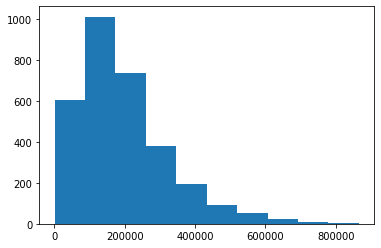

In [27]:
# get the coordinate of countys 
def geoToList(geodataframe):
    points = []
    for s in geodataframe.geometry:
        s = str(s)
        s = re.sub('[^-0-9., ]+', '', s).split(',')
        s = map(lambda x: x.strip(), s)
        s = map(lambda x: [float(x.split()[0]), float(x.split()[1])], s)
        # points.extend(list(s)) 
        s = list(s)
        m = np.mean(s,axis = 0)
#         print(m)
        points.append(m)
    return points
points = geoToList(df)
# print(len(points))

# get the coordinate of state captitals
import csv
import os
path = './data/'
file_name = 'us-state-capitals.csv'
csvFile = open(os.path.join(path, file_name), "r")
reader = csv.reader(csvFile)
result = {}
for item in reader:
    # 忽略第一行
    if reader.line_num == 1:
        continue
    result[item[0]] = (float(item[3]),float(item[2]))
# result


'''计算两点之间直线距离'''
def get_distance1(lon_a, lat_a, lon_b, lat_b):
    radlat1 = radians(lat_a)
    radlat2 = radians(lat_b)
    a = radlat1 - radlat2
    b = radians(lon_a) - radians(lon_b)
    s = 2 * asin(sqrt(pow(sin(a/2),2) + cos(radlat1) * cos(radlat2)*pow(sin(b/2),2)))
    earth_radius = 6378137
    s = s * earth_radius
    return s

# calculate all the distance between countys and their state captial
all_dist = []
for i in range(len(df)):
    captial_coord = result[df["STATE_NAME"].iloc[i]]
    dist = get_distance1(captial_coord[0], captial_coord[1], points[i][0], points[i][1])
    all_dist.append(dist)
# all_dist
plt.hist(all_dist)

In [28]:
df.index = range(0, len(df))
df["distance"] = 0

for i in range(len(all_dist)):
    df.loc[i,"distance"] = all_dist[i]
df    

,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,geometry,distance
0,Lake of the Woods,Minnesota,27,077,27077,"POLYGON ((-95.34283 48.54668, -95.34105 48.715...",457274.570523
1,Ferry,Washington,53,019,53019,"POLYGON ((-118.85163 47.94956, -118.84846 48.4...",366944.232094
2,Stevens,Washington,53,065,53065,"POLYGON ((-117.43883 48.04412, -117.54219 48.0...",394810.693837
3,Okanogan,Washington,53,047,53047,"POLYGON ((-118.97209 47.93915, -118.97406 47.9...",256435.574738
4,Pend Oreille,Washington,53,051,53051,"POLYGON ((-117.43858 48.99992, -117.03205 48.9...",447690.698678
...,...,...,...,...,...,...,...
3104,LaGrange,Indiana,18,087,18087,"POLYGON ((-85.66327 41.53557, -85.65946 41.762...",217950.155280
3105,Steuben,Indiana,18,151,18151,"POLYGON ((-84.79137 41.53049, -85.19715 41.537...",234989.738373
3106,Pittsylvania,Virginia,51,143,51143,"POLYGON ((-79.71720 36.54803, -79.64135 36.846...",187324.988626
3107,Danville,Virginia,51,590,51590,"POLYGON ((-79.51977 36.59777, -79.50138 36.621...",204708.799179


In [29]:
# every 40,000m draw a circle

def draw_circle(d):
    return int(d//40000)
#     return int(d//87000)

df['circle'] = df.apply(lambda x: draw_circle(x.distance), axis = 1)
df

,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,geometry,distance,circle
0,Lake of the Woods,Minnesota,27,077,27077,"POLYGON ((-95.34283 48.54668, -95.34105 48.715...",457274.570523,11
1,Ferry,Washington,53,019,53019,"POLYGON ((-118.85163 47.94956, -118.84846 48.4...",366944.232094,9
2,Stevens,Washington,53,065,53065,"POLYGON ((-117.43883 48.04412, -117.54219 48.0...",394810.693837,9
3,Okanogan,Washington,53,047,53047,"POLYGON ((-118.97209 47.93915, -118.97406 47.9...",256435.574738,6
4,Pend Oreille,Washington,53,051,53051,"POLYGON ((-117.43858 48.99992, -117.03205 48.9...",447690.698678,11
...,...,...,...,...,...,...,...,...
3104,LaGrange,Indiana,18,087,18087,"POLYGON ((-85.66327 41.53557, -85.65946 41.762...",217950.155280,5
3105,Steuben,Indiana,18,151,18151,"POLYGON ((-84.79137 41.53049, -85.19715 41.537...",234989.738373,5
3106,Pittsylvania,Virginia,51,143,51143,"POLYGON ((-79.71720 36.54803, -79.64135 36.846...",187324.988626,4
3107,Danville,Virginia,51,590,51590,"POLYGON ((-79.51977 36.59777, -79.50138 36.621...",204708.799179,5


# add covid

In [30]:
# load covid data
import pandas as pd
def read_file(path):
    dirs = os.listdir(path)
    all_states = {}
    for file_name in dirs:
        # print(file_name)
        csvFile = open(os.path.join(path, file_name), "r")
        reader = csv.reader(csvFile)
        # 建立空字典
        result = {}
        for item in reader:
            # 忽略第一行
            if reader.line_num == 1:
                continue
            result[item[0]] = item[2]
        csvFile.close()
        # print(result)
        all_states[file_name] = result
    return all_states

df["COVID"] = 0

sick_path = "./data/covid/"
sick_data = read_file(sick_path)
for key in sick_data.keys():
    for city in sick_data[key].keys():
        idx = df[df['NAME'].isin([city])].index
        df["COVID"][idx] = sick_data[key][city]

df["COVID"] = pd.to_numeric(df["COVID"])
df

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,geometry,distance,circle,COVID
0,Lake of the Woods,Minnesota,27,077,27077,"POLYGON ((-95.34283 48.54668, -95.34105 48.715...",457274.570523,11,0
1,Ferry,Washington,53,019,53019,"POLYGON ((-118.85163 47.94956, -118.84846 48.4...",366944.232094,9,1
2,Stevens,Washington,53,065,53065,"POLYGON ((-117.43883 48.04412, -117.54219 48.0...",394810.693837,9,9
3,Okanogan,Washington,53,047,53047,"POLYGON ((-118.97209 47.93915, -118.97406 47.9...",256435.574738,6,31
4,Pend Oreille,Washington,53,051,53051,"POLYGON ((-117.43858 48.99992, -117.03205 48.9...",447690.698678,11,2
...,...,...,...,...,...,...,...,...,...
3104,LaGrange,Indiana,18,087,18087,"POLYGON ((-85.66327 41.53557, -85.65946 41.762...",217950.155280,5,38
3105,Steuben,Indiana,18,151,18151,"POLYGON ((-84.79137 41.53049, -85.19715 41.537...",234989.738373,5,245
3106,Pittsylvania,Virginia,51,143,51143,"POLYGON ((-79.71720 36.54803, -79.64135 36.846...",187324.988626,4,17
3107,Danville,Virginia,51,590,51590,"POLYGON ((-79.51977 36.59777, -79.50138 36.621...",204708.799179,5,39


# add population

In [31]:
# load population data
population_path = './data/covid_county_population_usafacts.csv'
population_data = pd.read_csv(population_path)
# Display summary
# population_data.info()
# population_data

# some preprocess
population_data = population_data[~population_data["countyFIPS"].isin([0])]
population_data["countyFIPS"] = population_data["countyFIPS"].apply(lambda x: '{:0>5d}'.format(x))
population_data["countyFIPS"] = population_data["countyFIPS"].astype('object')
# population_data
group_county = population_data.groupby("countyFIPS").sum()
# group_county
# integrate
df = pd.merge(df, group_county[['population']],
                left_on=['FIPS'],
                right_on=["countyFIPS"] ,
                how='left')
# only let the missing data of population be 0
df["population"] = df["population"].fillna(0)
df 

,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,geometry,distance,circle,COVID,population
0,Lake of the Woods,Minnesota,27,077,27077,"POLYGON ((-95.34283 48.54668, -95.34105 48.715...",457274.570523,11,0,3740.0
1,Ferry,Washington,53,019,53019,"POLYGON ((-118.85163 47.94956, -118.84846 48.4...",366944.232094,9,1,7627.0
2,Stevens,Washington,53,065,53065,"POLYGON ((-117.43883 48.04412, -117.54219 48.0...",394810.693837,9,9,45723.0
3,Okanogan,Washington,53,047,53047,"POLYGON ((-118.97209 47.93915, -118.97406 47.9...",256435.574738,6,31,42243.0
4,Pend Oreille,Washington,53,051,53051,"POLYGON ((-117.43858 48.99992, -117.03205 48.9...",447690.698678,11,2,13724.0
...,...,...,...,...,...,...,...,...,...,...
3104,LaGrange,Indiana,18,087,18087,"POLYGON ((-85.66327 41.53557, -85.65946 41.762...",217950.155280,5,38,39614.0
3105,Steuben,Indiana,18,151,18151,"POLYGON ((-84.79137 41.53049, -85.19715 41.537...",234989.738373,5,245,34594.0
3106,Pittsylvania,Virginia,51,143,51143,"POLYGON ((-79.71720 36.54803, -79.64135 36.846...",187324.988626,4,17,60354.0
3107,Danville,Virginia,51,590,51590,"POLYGON ((-79.51977 36.59777, -79.50138 36.621...",204708.799179,5,39,40044.0


# add beds


In [32]:
hospital_path = './data/Hospitals/Hospitals.shp'
shape_hospital = gpd.read_file(hospital_path)
# Display summary
# shape_hospital.info()
# process the bed data
shape_hospital["BEDS"] = shape_hospital["BEDS"].replace(-999, 0)
shape_hospital["BEDS"] = shape_hospital["BEDS"].fillna(0)
g = shape_hospital.groupby("COUNTYFIPS").sum()
# g
df = df.merge(g[['BEDS']],
                     left_on='FIPS',
                     right_on='COUNTYFIPS',
                     how='left')
# only let the missing data of beds be 0
df["BEDS"] = df["BEDS"].fillna(0)
df

,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,geometry,distance,circle,COVID,population,BEDS
0,Lake of the Woods,Minnesota,27,077,27077,"POLYGON ((-95.34283 48.54668, -95.34105 48.715...",457274.570523,11,0,3740.0,15.0
1,Ferry,Washington,53,019,53019,"POLYGON ((-118.85163 47.94956, -118.84846 48.4...",366944.232094,9,1,7627.0,25.0
2,Stevens,Washington,53,065,53065,"POLYGON ((-117.43883 48.04412, -117.54219 48.0...",394810.693837,9,9,45723.0,90.0
3,Okanogan,Washington,53,047,53047,"POLYGON ((-118.97209 47.93915, -118.97406 47.9...",256435.574738,6,31,42243.0,91.0
4,Pend Oreille,Washington,53,051,53051,"POLYGON ((-117.43858 48.99992, -117.03205 48.9...",447690.698678,11,2,13724.0,74.0
...,...,...,...,...,...,...,...,...,...,...,...
3104,LaGrange,Indiana,18,087,18087,"POLYGON ((-85.66327 41.53557, -85.65946 41.762...",217950.155280,5,38,39614.0,25.0
3105,Steuben,Indiana,18,151,18151,"POLYGON ((-84.79137 41.53049, -85.19715 41.537...",234989.738373,5,245,34594.0,25.0
3106,Pittsylvania,Virginia,51,143,51143,"POLYGON ((-79.71720 36.54803, -79.64135 36.846...",187324.988626,4,17,60354.0,0.0
3107,Danville,Virginia,51,590,51590,"POLYGON ((-79.51977 36.59777, -79.50138 36.621...",204708.799179,5,39,40044.0,250.0



# add health ranking

In [33]:
def read_excel(path, filename):

    # df = pd.DataFrame(columns=["counties", "FIPS", "health_outcomes",
    #                            "health_behaviors", "clinical_care", "poor_or_fair",
    #                            "uninsured", "primary_care", "preventable_hospital", "flu_vaccinations",
    #                            "unemployment", "social_associations", "air_pollution",
    #                            "life_expectancy"])
    df = pd.DataFrame()
    wb = xlrd.open_workbook(os.path.join(path, filename))

    # print(wb.sheet_names()) # get all the names of tab
    sheet_ranking = wb.sheet_by_index(1)
    sheet_subranking = wb.sheet_by_index(2)
    sheet_measure = wb.sheet_by_index(3)
    sheet_additional = wb.sheet_by_index(4)

    # Outcomes&Factors Rankings
    state_name = sheet_ranking.cell(2, 1).value
    df[sheet_ranking.cell(1, 0).value] = sheet_ranking.col_values(0)[3:]  # FIPS
    df["County"] = sheet_ranking.col_values(2)[3:]  # county
    df["health_outcomes"] = sheet_ranking.col_values(4)[3:]  # health_outcomes
    # Outcomes&Factors SubRankings
    df["health_behaviors"] = sheet_subranking.col_values(8)[3:]
    df["clinical_care"] = sheet_subranking.col_values(10)[3:]
    # Ranked Measure Data
    df[sheet_measure.cell(1,23).value] = sheet_measure.col_values(23)[3:]  # percentage
    df[sheet_measure.cell(1,104).value] = sheet_measure.col_values(104)[3:]  # percentage
    df[sheet_measure.cell(1,110).value] = sheet_measure.col_values(110)[3:]  # ratio
    df[sheet_measure.cell(1,120).value] = sheet_measure.col_values(120)[3:]  # rate
    df[sheet_measure.cell(1,134).value] = sheet_measure.col_values(134)[3:]  # percentage
    df[sheet_measure.cell(1,152).value] = sheet_measure.col_values(152)[3:]  # percentage
    df[sheet_measure.cell(1,174).value] = sheet_measure.col_values(174)[3:]  # rate
    df[sheet_measure.cell(1,199).value] = sheet_measure.col_values(199)[3:]  # average daily pm2.5
    # Additional Measure Data
    df[sheet_additional.cell(1,3).value] = sheet_additional.col_values(3)[3:]
#     print(df[[sheet_subranking.cell(1, 8).value]])

    df.to_csv(os.path.join(path, "processed/{}.csv".format(state_name)))

healthranking_path = "./data/healthranking/"

dirs = os.listdir(healthranking_path)
for filename in dirs:
    if os.path.splitext(filename)[-1] == ".xlsx":
        read_excel(healthranking_path, filename)

processed_healthranking_path = "./data/healthranking/processed/"
all_state = pd.DataFrame()
for state in sorted(os.listdir(processed_healthranking_path)):
    state_data = pd.read_csv(os.path.join(processed_healthranking_path, state))
    state_data["FIPS"] = state_data["FIPS"].apply(lambda x: '{:0>5d}'.format(x))
    state_data["FIPS"] = state_data["FIPS"].astype('object')
#     state_data.info()
    all_state = pd.concat([all_state,state_data],sort=False)
# all_state.info()
# all_state

df = pd.merge(df, all_state[list(all_state.columns[1:])],
                on='FIPS',
                how='left')
df.info()
df

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3109 entries, 0 to 3108
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   NAME                              3109 non-null   object  
 1   STATE_NAME                        3109 non-null   object  
 2   STATE_FIPS                        3109 non-null   object  
 3   CNTY_FIPS                         3109 non-null   object  
 4   FIPS                              3109 non-null   object  
 5   geometry                          3109 non-null   geometry
 6   distance                          3109 non-null   float64 
 7   circle                            3109 non-null   int64   
 8   COVID                             3109 non-null   int64   
 9   population                        3109 non-null   float64 
 10  BEDS                              3109 non-null   float64 
 11  County                            3107 non-null 

,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,geometry,distance,circle,COVID,population,...,clinical_care,% Fair or Poor Health,% Uninsured,Primary Care Physicians Ratio,Preventable Hospitalization Rate,% Vaccinated,% Unemployed,Social Association Rate,Average Daily PM2.5,Life Expectancy
0,Lake of the Woods,Minnesota,27,077,27077,"POLYGON ((-95.34283 48.54668, -95.34105 48.715...",457274.570523,11,0,3740.0,...,80,12.342218,6.380716,1872:1,6367.0,21.0,3.783784,32.051282,5.9,79.758121
1,Ferry,Washington,53,019,53019,"POLYGON ((-118.85163 47.94956, -118.84846 48.4...",366944.232094,9,1,7627.0,...,32,19.095582,10.597232,1519:1,2123.0,17.0,11.736334,7.900974,6.5,77.375074
2,Stevens,Washington,53,065,53065,"POLYGON ((-117.43883 48.04412, -117.54219 48.0...",394810.693837,9,9,45723.0,...,26,17.331614,7.853357,1443:1,2958.0,29.0,7.122259,8.048290,9.0,79.498064
3,Okanogan,Washington,53,047,53047,"POLYGON ((-118.97209 47.93915, -118.97406 47.9...",256435.574738,6,31,42243.0,...,39,18.305381,14.912089,1347:1,2936.0,21.0,6.396578,13.655311,7.1,78.703023
4,Pend Oreille,Washington,53,051,53051,"POLYGON ((-117.43858 48.99992, -117.03205 48.9...",447690.698678,11,2,13724.0,...,25,16.812173,8.024880,1908:1,2558.0,29.0,7.169576,6.739554,9.0,77.238157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3104,LaGrange,Indiana,18,087,18087,"POLYGON ((-85.66327 41.53557, -85.65946 41.762...",217950.155280,5,38,39614.0,...,92,16.502851,24.854621,3930:1,4213.0,47.0,2.498423,8.650739,12.7,79.451100
3105,Steuben,Indiana,18,151,18151,"POLYGON ((-84.79137 41.53049, -85.19715 41.537...",234989.738373,5,245,34594.0,...,37,16.458553,9.558573,3135:1,3741.0,48.0,2.663260,13.629509,12.0,79.961697
3106,Pittsylvania,Virginia,51,143,51143,"POLYGON ((-79.71720 36.54803, -79.64135 36.846...",187324.988626,4,17,60354.0,...,76,18.229615,12.836319,12252:1,3750.0,50.0,3.552020,14.038983,10.1,76.960306
3107,Danville,Virginia,51,590,51590,"POLYGON ((-79.51977 36.59777, -79.50138 36.621...",204708.799179,5,39,40044.0,...,38,21.940664,10.552796,979:1,5475.0,50.0,5.051331,21.881838,10.0,72.355913


# deal with missing values

In [34]:
df["Primary Care Physicians Ratio"] = df["Primary Care Physicians Ratio"].astype("str")
df["Primary Care Physicians Ratio"] = df["Primary Care Physicians Ratio"].apply(lambda x: x.split(":")[0])

# remove 'None' 'NR' 'nan', calculate the mean of each state
state_df = copy.copy(df[df.isnull().values==False])
state_df = state_df[~state_df['health_outcomes'].isin(['NR'])]
state_df = state_df[~state_df['health_behaviors'].isin(['NR'])]
state_df = state_df[~state_df['clinical_care'].isin(['NR'])]

state_df = state_df[~state_df["Primary Care Physicians Ratio"].isin(['None'])]
state_df["health_outcomes"] = state_df["health_outcomes"].astype("float")
state_df["health_behaviors"] = state_df["health_behaviors"].astype("float")
state_df["clinical_care"] = state_df["clinical_care"].astype("float")
state_df["Primary Care Physicians Ratio"] = state_df["Primary Care Physicians Ratio"].astype("float")
state_mean = state_df[state_df.isnull().values==False].groupby("STATE_FIPS").mean()
state_mean
# df.info()

,distance,circle,COVID,population,BEDS,health_outcomes,health_behaviors,clinical_care,% Fair or Poor Health,% Uninsured,Primary Care Physicians Ratio,Preventable Hospitalization Rate,% Vaccinated,% Unemployed,Social Association Rate,Average Daily PM2.5,Life Expectancy
STATE_FIPS,,,,,,,,,,,,,,,,,
01,150925.570254,3.209215,197.438356,73257.765878,283.935243,33.978829,33.993773,33.998755,23.815469,11.743092,2818.861538,6161.342466,38.506227,4.494686,11.193259,11.091594,74.645440
04,194307.621548,4.533333,751.600000,485247.800000,1030.133333,8.000000,8.000000,8.000000,19.875900,13.212600,2233.800000,3248.266667,38.000000,6.713043,6.034375,6.913333,78.521663
05,144306.517112,3.119511,135.686492,40255.443580,156.073374,38.013897,38.017232,38.003891,23.303882,9.419147,3128.418919,5634.976098,40.807671,4.247814,11.363220,10.016620,74.904933
06,242129.305056,5.589850,1138.184647,682203.392734,1796.216660,29.495069,29.479572,29.479572,16.185673,7.842812,1777.511226,3413.295765,39.353407,5.236840,6.105763,10.142598,80.308461
08,191052.958450,4.264407,257.943333,96361.562860,199.216433,30.431703,30.446008,30.446357,14.520681,10.636220,1987.961116,2842.787273,40.938449,3.340912,10.332644,5.474094,80.959703
09,40486.876292,0.500000,2409.125000,445660.875000,1181.375000,4.500000,4.500000,4.500000,11.817605,5.449130,1507.875000,4179.125000,53.875000,3.997222,9.422372,8.200000,80.607635
10,34916.974121,0.666667,1094.333333,324588.000000,926.666667,2.000000,2.000000,2.000000,17.856453,6.385969,1653.000000,5174.000000,54.000000,3.850953,10.083468,9.500000,78.238103
11,520.644735,0.000000,0.000000,705749.000000,4304.000000,1.000000,1.000000,1.000000,13.033794,4.300578,851.000000,5520.000000,38.000000,5.553496,28.747558,9.700000,78.591976
12,285386.456109,6.701743,1081.732877,320948.644458,1077.280199,33.998132,33.972603,33.970735,20.091382,15.813227,2944.107692,5657.460149,39.042341,3.792386,8.350148,8.388294,78.036262


In [35]:
# fill the missing values
grouped = df.groupby('STATE_FIPS')
filled_df = gpd.GeoDataFrame()

for fip in list(set(df.STATE_FIPS)):
    g = grouped.get_group(fip)
    values = state_mean.loc[fip]
#     print(values)
    g = g.fillna(value=values)
    g = g.replace('None', value=values)
    g = g.replace('NR', value=values)
    g = g.replace('nan', value=values)
#     print(g)
    filled_df = pd.concat([filled_df,g],sort=False)

# convert to the original order 
filled_df = pd.merge(df[list(df.columns)[:5]],filled_df[list(filled_df.columns)[4:]],on="FIPS",how="left")
filled_df = gpd.GeoDataFrame(filled_df)

In [36]:
# check if still has missing data
filled_df[filled_df.isnull().values==True]

,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,geometry,distance,circle,COVID,population,...,clinical_care,% Fair or Poor Health,% Uninsured,Primary Care Physicians Ratio,Preventable Hospitalization Rate,% Vaccinated,% Unemployed,Social Association Rate,Average Daily PM2.5,Life Expectancy
422,Shannon,South Dakota,46,113,46113,"POLYGON ((-102.78838 42.99530, -103.00588 42.9...",206327.093587,5,0,0.0,...,30.4787,13.582869,13.212252,2137.14,5097.122164,36.628486,3.482781,14.677685,5.952256,78.094864
1663,Bedford City,Virginia,51,515,51515,"POLYGON ((-79.49441 37.33362, -79.49787 37.311...",185666.412210,4,0,0.0,...,67.0348,16.695872,11.292814,2821.87,4809.796886,48.438430,3.388950,12.450078,8.951746,77.619836


In [37]:
filled_df.loc[1663]

NAME                                                                     Bedford City
STATE_NAME                                                                   Virginia
STATE_FIPS                                                                         51
CNTY_FIPS                                                                         515
FIPS                                                                            51515
geometry                            POLYGON ((-79.49441325181641 37.33361862438002...
distance                                                                       185666
circle                                                                              4
COVID                                                                               0
population                                                                          0
BEDS                                                                               50
County                                                

In [38]:
# save the result
outputpath = "./data/Processed_data/"
if not os.path.exists(outputpath):
    os.makedirs(outputpath)
filled_df.to_file(os.path.join(outputpath, "processed_data.shp"))

# visualize datasets


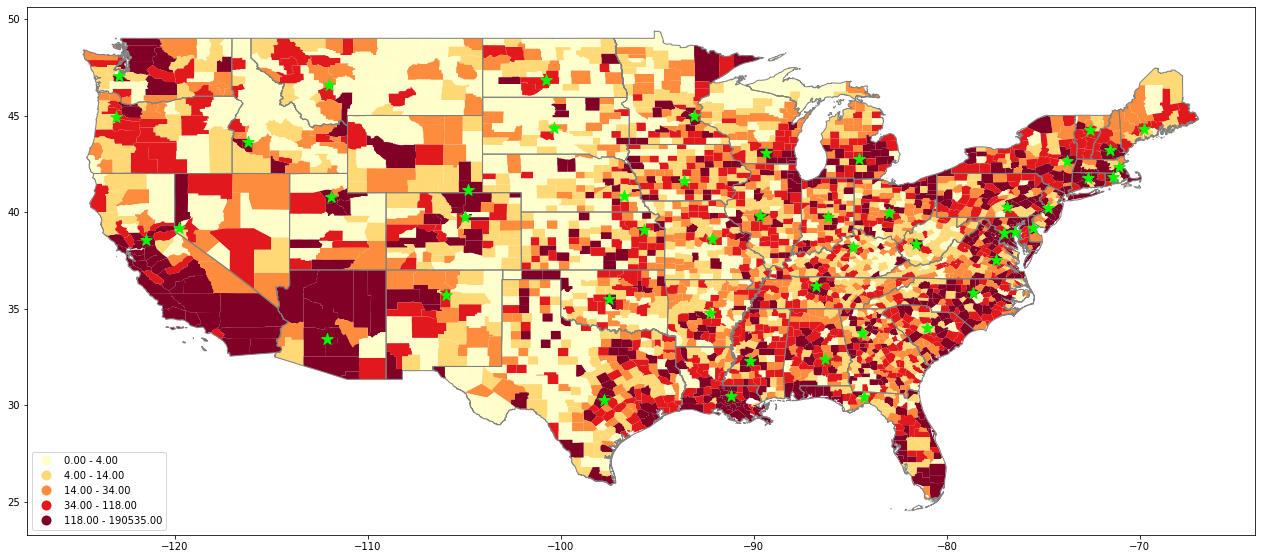

In [58]:
base = df.plot(column='COVID',cmap='YlOrRd', scheme='quantiles', figsize=(22,10), legend=True, legend_kwds=dict(loc='lower left',  frameon=True))
shape_state.plot(ax=base, color='none', edgecolor='grey')
captial_data.plot(ax=base, color='lime', marker='*', markersize=150)
plt.savefig("./pic/dataset_covid")

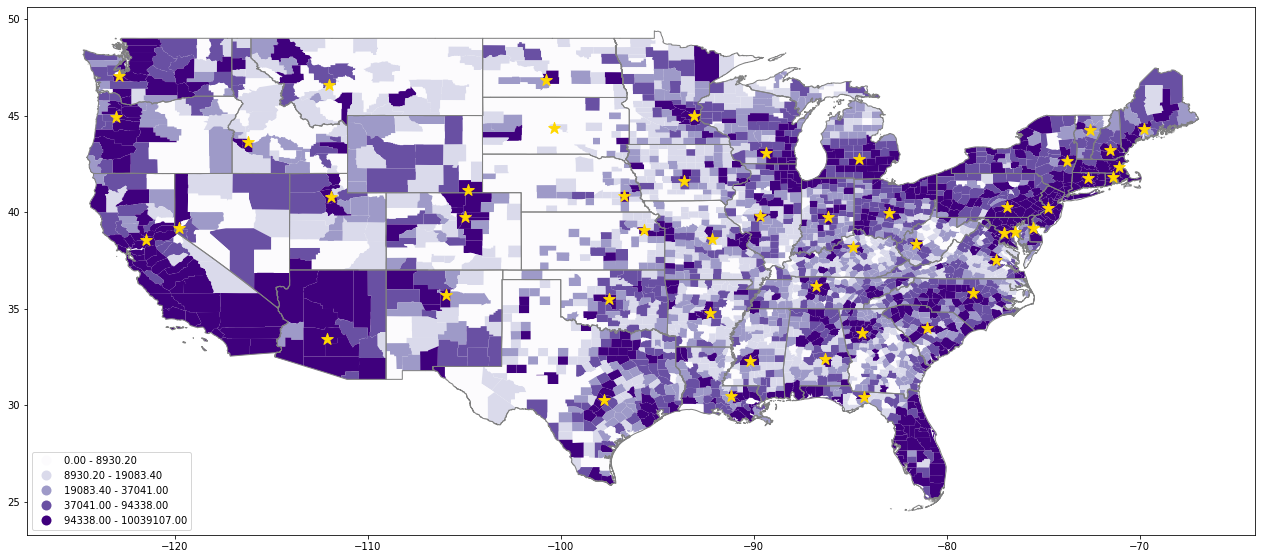

In [59]:
base = df.plot(column='population',cmap='Purples', scheme='quantiles', figsize=(22,10), legend=True, legend_kwds=dict(loc='lower left',  frameon=True))
shape_state.plot(ax=base, color='none', edgecolor='grey')
captial_data.plot(ax=base, color='gold', marker='*', markersize=150)
plt.savefig("./pic/dataset_pop")

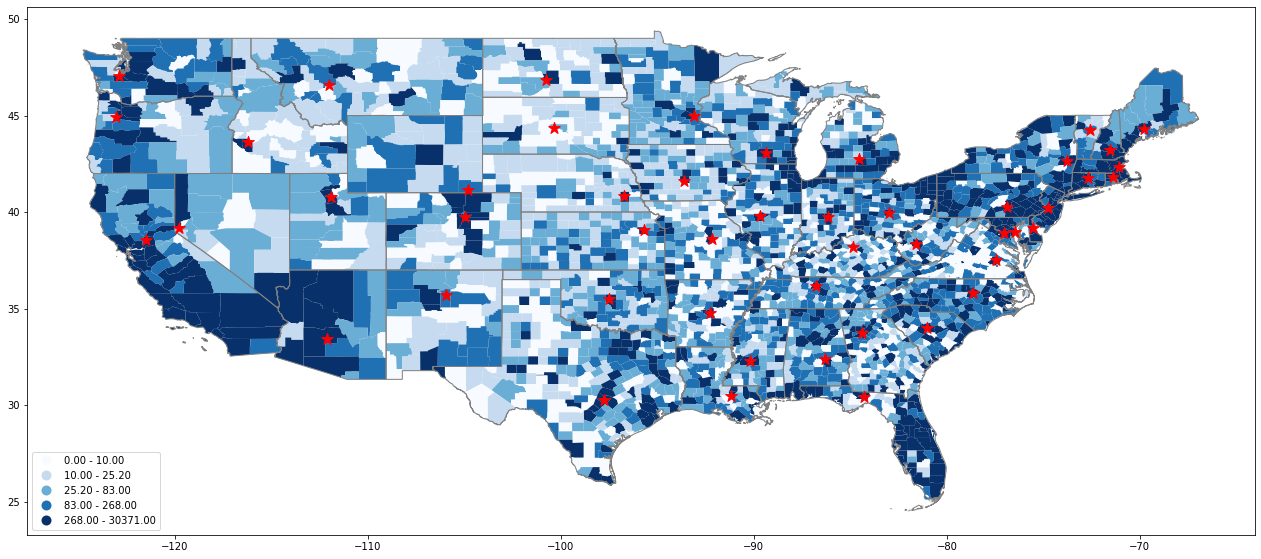

In [60]:
base = df.plot(column='BEDS',cmap='Blues', scheme='quantiles', figsize=(22,10), legend=True, legend_kwds=dict(loc='lower left',  frameon=True))
shape_state.plot(ax=base, color='none', edgecolor='grey')
captial_data.plot(ax=base, color='red', marker='*', markersize=150)
plt.savefig("./pic/dataset_bed")